모듈 임포트 및 실험 변수 설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets,transforms
import numpy as np
import matplotlib.pyplot as plt
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

Mounted at /content/drive
cuda


In [2]:
import random
random_seed = 0
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

In [3]:
BATCH_SIZE = 32
LR = 1e-3
EPOCH = 50
criterion = nn.CrossEntropyLoss()

데이터셋 준비

In [4]:
TARGET_IMG_SIZE = 224
CIFAR10_TRAIN_MEAN = (0.4914, 0.4822, 0.4465) # 원본 CIFAR-10 통계치
CIFAR10_TRAIN_STD = (0.2470, 0.2435, 0.2616) # 원본 CIFAR-10 통계치

# 기본 transform (업샘플링 + Tensor 변환 + 정규화)
transform_upsampled = transforms.Compose([
    transforms.Resize((TARGET_IMG_SIZE, TARGET_IMG_SIZE), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_TRAIN_MEAN, CIFAR10_TRAIN_STD)
])

# 기본 학습 데이터셋 (Augmentation 없음)
train_DS = datasets.CIFAR10(
    root = '/content/drive/MyDrive/Colab Notebooks/data',
    train=True,
    download=True,
    transform=transform_upsampled
)

# 기본 테스트 데이터셋 (Augmentation 없음)
test_DS = datasets.CIFAR10(
    root = '/content/drive/MyDrive/Colab Notebooks/data',
    train=False,
    download=True,
    transform=transform_upsampled
)

In [5]:
g = torch.Generator()
g.manual_seed(random_seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# 기본 학습 데이터로더 (Augmentation 미적용)
train_DL = torch.utils.data.DataLoader(
    train_DS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    generator=g,
    worker_init_fn=seed_worker,
    pin_memory=True
)

# 기본 테스트 데이터로더 (당연히 Augmentation 미적용)
test_DL = torch.utils.data.DataLoader(
    test_DS,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    generator=g,
    worker_init_fn=seed_worker,
    pin_memory=True
)

In [6]:
# # Augmentation용 transform (업샘플링 + Augmentation + Tensor 변환 + 정규화)
# transform_train_augmented_upsampled = transforms.Compose([
#     transforms.Resize((TARGET_IMG_SIZE, TARGET_IMG_SIZE), interpolation=transforms.InterpolationMode.BILINEAR),
#     transforms.RandomHorizontalFlip(p=0.5), # 50% 확률로 좌우 반전
#     transforms.RandomCrop(TARGET_IMG_SIZE, padding=int(TARGET_IMG_SIZE * 0.1), padding_mode='reflect'), # 10% 패딩 후 랜덤 크롭
#     # 필요시 다른 증강 기법 추가 가능 (예: ColorJitter)
#     # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.ToTensor(),
#     transforms.Normalize(CIFAR10_TRAIN_MEAN, CIFAR10_TRAIN_STD)
# ])

# 위는 맨 처음에 내가 만든 Augmentation용 transform 코드



# 아래는 2번째 실험방식 (실시간 증강을 그대로 적용하되, 일정확률로 원본 이미지 그대로를 학습하는 경우도 추가하는 방식)

# 1. 조건부로 적용할 증강 기법들을 정의합니다.
conditional_augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), # 이 블록이 적용될 때, 내부적으로 50% 확률로 반전
    transforms.RandomCrop(TARGET_IMG_SIZE, padding=int(TARGET_IMG_SIZE * 0.1), padding_mode='reflect')
])

# 2. 새로운 학습용 transform 파이프라인 정의
#    예: 50% 확률로 conditional_augmentations를 적용하고, 50% 확률로는 적용하지 않음 (Resize만 된 상태)

transform_train_augmented_upsampled = transforms.Compose([
    # 항상 적용되는 초기 Resize
    transforms.Resize((TARGET_IMG_SIZE, TARGET_IMG_SIZE), interpolation=transforms.InterpolationMode.BILINEAR),
    # conditional_augmentations 블록 전체를 prob_apply_conditional_augs 확률로 적용
    transforms.RandomApply(
        # RandomApply는 nn.Module로 구성된 리스트를 받는 것이 일반적이지만,
        # transforms 객체들의 리스트를 직접 사용할 수도 있습니다.
        # 여기서는 Compose 객체 하나를 리스트에 넣어 전달합니다.
        [conditional_augmentations],
        p=0.2
    ),
    # 항상 적용되는 최종 변환
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_TRAIN_MEAN, CIFAR10_TRAIN_STD)
])


# Augmentation용 학습 데이터셋 (Augmentation 적용)
train_DS_augmented = datasets.CIFAR10(
    root = '/content/drive/MyDrive/Colab Notebooks/data', # 데이터 저장 경로
    train=True,
    download=True,
    transform=transform_train_augmented_upsampled # Augmentation용 transform 사용
)

# Augmentation용 학습 데이터로더 (Augmentation 적용)
train_DL_augmented = torch.utils.data.DataLoader(
    train_DS_augmented,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    generator=g,
    worker_init_fn=seed_worker,
    pin_memory=True
)

In [7]:
print(f"Number of training samples: {len(train_DS)}")
print(f"Number of test samples: {len(test_DS)}")
print(f"Shape of one training sample: {train_DS[0][0].shape}")
print(f"Data type of one training sample: {train_DS[0][0].dtype}")
print(f"Label of one training sample: {train_DS[0][1]}")

Number of training samples: 50000
Number of test samples: 10000
Shape of one training sample: torch.Size([3, 224, 224])
Data type of one training sample: torch.float32
Label of one training sample: 6


AlexNet

In [8]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),  # 첫번째 Conv
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),           # 두번째 Conv
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),          # 세번째 Conv
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),          # 네번째 Conv
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),          # 다섯번째 Conv
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))                 # Adaptive Pooling
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),                           # Fully Connected 1
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),                                  # Fully Connected 2
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),                           # 출력층
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

Train & Test Function

In [9]:
def Train(model, train_DL, criterion):
    optimizer = optim.Adam(model.parameters(), lr=LR)

    loss_history=[]
    acc_history=[]

    NoT = len(train_DL.dataset)

    model.train()

    for ep in range(EPOCH):
        rloss = 0
        rcorrect = 0

        for x_batch, y_batch in train_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            y_hat = model(x_batch)
            loss = criterion(y_hat, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_b = loss.item() * x_batch.shape[0]
            rloss += loss_b
            pred = y_hat.argmax(dim=1)
            corrects_b = torch.sum(pred == y_batch).item()
            rcorrect += corrects_b

        loss_e = rloss/NoT
        accuracy_e = rcorrect/NoT * 100
        loss_history += [loss_e]
        acc_history += [accuracy_e]
        print(f"Epoch: {ep+1}, train loss: {round(loss_e,3)}, train accuracy: {round(accuracy_e,1)} %")
        print("-"*20)

    return loss_history, acc_history

In [10]:
def Test(model,test_DL):
    model.eval()
    with torch.no_grad():
        rcorrect = 0
        for x_batch, y_batch in test_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            y_hat = model(x_batch)
            pred = y_hat.argmax(dim=1)
            corrects_b = torch.sum(pred == y_batch).item()
            rcorrect += corrects_b
        accuracy_e = rcorrect/len(test_DL.dataset)*100
    print(f"Test accuracy: {rcorrect}/{len(test_DL.dataset)} ({round(accuracy_e,1)} %)")
    return round(accuracy_e,1)

**실험 1**: Data Augmentation 성능 확인 (in AlexNet)

In [11]:
model_no_aug=AlexNet().to(DEVICE)
print(model_no_aug)
x_batch, _ = next(iter(train_DL))
print(model_no_aug(x_batch.to(DEVICE)).shape)

print("="*30)
print(" Data Augmentation 적용하지 않은 상태로 AlexNet 학습")
print("="*30)

loss_history_no_aug, acc_history_no_aug = Train(model_no_aug, train_DL, criterion)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [12]:
print("="*30)
print("Data Augmentation 적용하지 않은 AlexNet 테스트")
print("="*30)
# Test 함수로 평가
test_accuracy_no_aug = Test(model_no_aug, test_DL)

Data Augmentation 적용하지 않은 AlexNet 테스트
Test accuracy: 6843/10000 (68.4 %)


In [13]:
model_aug=AlexNet().to(DEVICE)
print(model_aug)
x_batch, _ = next(iter(train_DL_augmented))
print(model_aug(x_batch.to(DEVICE)).shape)

print("="*30)
print("실험 1: Data Augmentation 적용한 상태로 AlexNet 학습")
print("="*30)

loss_history_aug, acc_history_aug = Train(model_aug, train_DL_augmented, criterion)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [14]:
print("="*30)
print("Data Augmentation 적용한 AlexNet 테스트")
print("="*30)
# Test 함수로 평가
test_accuracy_aug = Test(model_aug, test_DL)

Data Augmentation 적용한 AlexNet 테스트
Test accuracy: 6222/10000 (62.2 %)


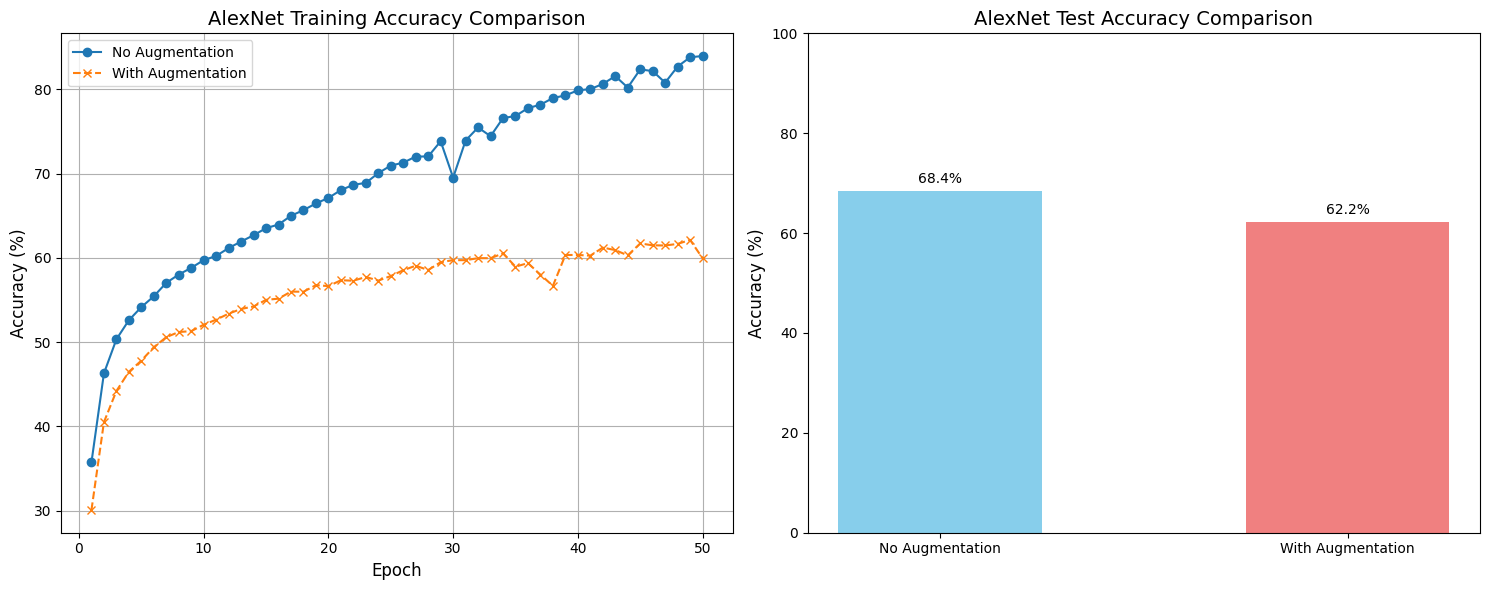

In [15]:
# 에폭 범위 (X축으로 사용)
epochs_range = range(1, EPOCH + 1)

# 전체 그림(figure)의 크기를 설정합니다. (플롯 2개용으로 너비 조정)
plt.figure(figsize=(15, 6)) # 이전보다 너비를 약간 줄여도 괜찮습니다.

# 1. 학습 정확도(Training Accuracy) 비교
plt.subplot(1, 2, 1) # 1행 2열의 첫 번째 플롯
plt.plot(epochs_range, acc_history_no_aug, marker='o', linestyle='-', label='No Augmentation')
plt.plot(epochs_range, acc_history_aug, marker='x', linestyle='--', label='With Augmentation')
plt.title('AlexNet Training Accuracy Comparison', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# 2. 최종 테스트 정확도(Final Test Accuracy) 비교 (막대 그래프)
plt.subplot(1, 2, 2) # 1행 2열의 두 번째 플롯
labels = ['No Augmentation', 'With Augmentation']
test_accuracies = [test_accuracy_no_aug, test_accuracy_aug]

bars = plt.bar(labels, test_accuracies, color=['skyblue', 'lightcoral'], width=0.5)
plt.title('AlexNet Test Accuracy Comparison', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(0, 100) # Y축 범위를 0에서 100으로 설정 (정확도는 백분율)

# 각 막대 위에 정확도 값을 표시합니다.
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1.0, f'{yval:.1f}%', ha='center', va='bottom', fontsize=10)

# 플롯들이 겹치지 않도록 레이아웃을 조정합니다.
plt.tight_layout()
# 플롯을 화면에 표시합니다.
plt.show()

**실험 2:** 3x3 Convolution 3번 vs 7x7 Convolution 1번 (in VGG16)    

In [16]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 224 -> 112

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 112 -> 56

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 56 -> 28

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 28 -> 14

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 14 -> 7
        )

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), # Block 5의 마지막 Conv2d 출력 채널은 512
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [17]:
class VGG16_7x7(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16_7x7, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 224 -> 112

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 112 -> 56

            # Block 3
            nn.Conv2d(128, 256, kernel_size=7, padding=3), # 원본 VGG 16과 다르게, 7x7 conv 1번으로 변경
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 56 -> 28

            # Block 4
            nn.Conv2d(256, 512, kernel_size=7, padding=3), # 원본 VGG 16과 다르게, 7x7 conv 1번으로 변경
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 56 -> 28

            # Block 5
            nn.Conv2d(512, 512, kernel_size=7, padding=3), # 원본 VGG 16과 다르게, 7x7 conv 1번으로 변경
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 56 -> 28
        )

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), # Block 5의 마지막 Conv2d 출력 채널은 512
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [20]:
g = torch.Generator()
g.manual_seed(random_seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# 기본 학습 데이터로더 (Augmentation 미적용)
train_DL = torch.utils.data.DataLoader(
    train_DS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    generator=g,
    worker_init_fn=seed_worker,
    pin_memory=True
)

# 기본 테스트 데이터로더 (당연히 Augmentation 미적용)
test_DL = torch.utils.data.DataLoader(
    test_DS,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    generator=g,
    worker_init_fn=seed_worker,
    pin_memory=True
)

In [21]:
import time

print("="*30)
print("표준 VGG16 모델 학습 (3x3 Convolution만 이용)")
print("="*30)

model_vgg16_3x3 = VGG16().to(DEVICE) # 이전에 정의한 표준 VGG16 클래스
print(model_vgg16_3x3)

# 1. 파라미터 수 계산
total_params_3x3 = sum(p.numel() for p in model_vgg16_3x3.parameters() if p.requires_grad)
print(f"\n표준 VGG16 파라미터 수: {total_params_3x3:,}")

# 2. 학습 연산 시간 측정
print(f"\n\n학습 시작")
start_time_3x3 = time.time()
loss_history_3x3, acc_history_3x3 = Train(model_vgg16_3x3, train_DL, criterion)
end_time_3x3 = time.time()
training_time_3x3 = end_time_3x3 - start_time_3x3
print(f"\nVGG16_3x3 총 학습 시간: {training_time_3x3:.2f} 초")

# 3. 분류 성능 평가
print("\nVGG16_3x3 테스트")
test_accuracy_3x3 = Test(model_vgg16_3x3, test_DL)


표준 VGG16 모델 학습 (3x3 Convolution만 이용)
VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_

KeyboardInterrupt: 

In [ ]:
print("="*30)
print("7*7 Convolution으로 Custom한 VGG16 모델 학습 (3,4,5번째 블록만 변경)")
print("="*30)

model_vgg16_7x7 = VGG16_7x7().to(DEVICE) # 이전에 정의한 표준 VGG16 클래스
print(model_vgg16_7x7)

# 1. 파라미터 수 계산
total_params_7x7 = sum(p.numel() for p in model_vgg16_7x7.parameters() if p.requires_grad)
print(f"\n표준 VGG16 파라미터 수: {total_params_7x7:,}")

# 2. 학습 연산 시간 측정
print(f"\n\n학습 시작")
start_time_7x7 = time.time()
loss_history_7x7, acc_history_7x7 = Train(model_vgg16_7x7, train_DL, criterion)
end_time_7x7 = time.time()
training_time_7x7 = end_time_7x7 - start_time_7x7
print(f"\nVGG16_7x7 총 학습 시간: {training_time_7x7:.2f} 초")

# 3. 분류 성능 평가
print("\nVGG16_7x7 테스트")
test_accuracy_7x7 = Test(model_vgg16_7x7, test_DL)

In [ ]:
# 플롯 생성
epochs_range = range(1, EPOCH + 1)
model_labels = ['VGG16 (3x3 Conv)', 'VGG16 (7x7 Conv Customization)']

plt.figure(figsize=(18, 12)) # 4개의 플롯을 위한 크기 조정

# 1. 파라미터 수 비교
plt.subplot(2, 2, 1)
params_values = [total_params_3x3, total_params_7x7]
bars_params = plt.bar(model_labels, params_values, color=['skyblue', 'lightcoral'], width=0.5)
plt.title('모델 파라미터 수 비교', fontsize=14)
plt.ylabel('파라미터 수', fontsize=12)
plt.xticks(rotation=0, ha='center') # 레이블이 잘 보이도록 설정
# 막대 위에 값 표시
for bar in bars_params:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + max(params_values)*0.01, f'{int(yval):,}', ha='center', va='bottom', fontsize=10)
plt.grid(axis='y', linestyle='--')

# 2. 학습 시간 비교
plt.subplot(2, 2, 2)
time_values = [training_time_3x3, training_time_7x7]
bars_time = plt.bar(model_labels, time_values, color=['skyblue', 'lightcoral'], width=0.5)
plt.title('Train Time Comparison', fontsize=14)
plt.ylabel('시간 (sec)', fontsize=12)
plt.xticks(rotation=0, ha='center') # 레이블이 잘 보이도록 설정
# 막대 위에 값 표시
for bar in bars_time:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + max(time_values)*0.01, f'{yval:.2f}s', ha='center', va='bottom', fontsize=10)
plt.grid(axis='y', linestyle='--')

# 3. 에폭별 학습 정확도 비교
plt.subplot(2, 2, 3)
plt.plot(epochs_range, acc_history_3x3, marker='o', linestyle='-', label='VGG16 (3x3 Conv)')
plt.plot(epochs_range, acc_history_7x7, marker='x', linestyle='--', label='VGG16 (7x7 Conv Customization)')
plt.title('Train Accuracy Comparison', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Train Accuracy (%)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# 4. 최종 테스트 정확도 비교
plt.subplot(2, 2, 4)
test_accuracies_values = [test_accuracy_3x3, test_accuracy_7x7]
bars_test_acc = plt.bar(model_labels, test_accuracies_values, color=['skyblue', 'lightcoral'], width=0.5)
plt.title('Test Accuracy Comparison', fontsize=14)
plt.ylabel('정확도 (%)', fontsize=12)
plt.ylim(0, 100) # Y축 범위: 0에서 100 (정확도)
plt.xticks(rotation=0, ha='center') # 레이블이 잘 보이도록 설정
# 막대 위에 값 표시
for bar in bars_test_acc:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1.0, f'{yval:.1f}%', ha='center', va='bottom', fontsize=10)
plt.grid(axis='y', linestyle='--')

# 플롯들이 겹치지 않도록 레이아웃 조정
plt.tight_layout()
plt.show()